# Chapter 23 Ordinal Predicted Variable

In [1]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# numpyro
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.nn import softmax, softplus
from jax.scipy.special import logsumexp, logit, expit

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)  # 4 chains in MCMC

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scipy
import scipy.stats as stats
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,matplotlib,seaborn,scipy,arviz,numpyro,jax

pandas    : 1.2.1
numpy     : 1.19.5
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0
arviz     : 0.11.0
numpyro   : 0.5.0
jax       : 0.2.8



## Helper Functions

In [3]:
# these helper functions convert numpy array into jax.numpy array
# then after computation, convert back to numpy array
def prior_predictive(model, d):
    Pred = Predictive(model, num_samples=2021)
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    samples = Pred(random.PRNGKey(0), **jax_data)
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

def mcmc_sampling(model, d, num_warmup=500, num_samples=2000, num_chains=4):
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    # MCMC
    mcmc_engine = MCMC(NUTS(model), num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_engine.run(random.PRNGKey(0), **jax_data)
    samples = mcmc_engine.get_samples()
    #
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    mcmc_engine.print_summary()
    return np_samples

In [4]:
def plot_npdfs(a, method=None): #='hist'):
    fig, axes = plt.subplots(1, a.shape[1], figsize=(13,2))
    for i, ax in enumerate(axes):
        if method == 'hist':
            ax.hist(a[:,i], bins=20)
        else:
            az.plot_posterior(a[:,i], ax=ax)

In [5]:
def plot_thresholds(thresh_samples):
    thmat = thresh_samples # +1 is necessary to shift to the 1-based world as in DBDA book
    th_mean = np.repeat(thmat.mean(axis=1)[:,np.newaxis], nYlevels-1, axis=1)
    # the same dimensions: th_mean.shape, thmat.shape

    plt.vlines(x=thmat.mean(axis=0), ymin=th_mean.min(), ymax=th_mean.max(), 
               colors='#DDBBAA', linestyles='dashed', alpha=.4)
    plt.scatter(thmat, th_mean, alpha=.1, s=1);
    plt.xticks(ticks=thmat.mean(axis=0))
    plt.xlabel('thresholds')
    plt.ylabel('Mean Thresholds (per sample)')

## Data

In [6]:
# Using dtype 'category' for Y
df = pd.read_csv('data/OrdinalProbitData-1grp-1.csv', dtype={'Y':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Y       100 non-null    category
dtypes: category(1)
memory usage: 284.0 bytes


In [7]:
df.Y.value_counts(sort=False)

1    58
2    15
3    12
4     8
5     4
6     2
7     1
Name: Y, dtype: int64

In [8]:
# Number of outcomes
nYlevels = df.Y.cat.categories.size

thresh = np.arange(1.5, nYlevels, dtype=np.float32)
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5 2.5 3.5 4.5 5.5 6.5]
thresh_obs:	[1.5 -- -- -- -- 6.5]


#### Model

In [9]:
Y = df.Y.values.astype(int) - 1  # python index starts from 0
print(Y)
print(np.unique(Y))
print('nYlevels: ', nYlevels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 5 5 6]
[0 1 2 3 4 5 6]
nYlevels:  7


In [10]:
df.Y.value_counts() / len(df.Y)

1    0.58
2    0.15
3    0.12
4    0.08
5    0.04
6    0.02
7    0.01
Name: Y, dtype: float64

## Basic: Categorical + Dirichlet

In [11]:
def model_catder(nYlevels, y=None):
    probs = npr.sample('probs', dist.Dirichlet(jnp.ones(nYlevels)))
    obs = npr.sample('obs', dist.Categorical(probs=probs), obs=y)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  probs[0]      0.55      0.05      0.55      0.47      0.63  11722.53      1.00
  probs[1]      0.15      0.03      0.15      0.09      0.20  11146.27      1.00
  probs[2]      0.12      0.03      0.12      0.07      0.17  11043.56      1.00
  probs[3]      0.08      0.03      0.08      0.04      0.13  10634.82      1.00
  probs[4]      0.05      0.02      0.04      0.02      0.08  10744.28      1.00
  probs[5]      0.03      0.02      0.03      0.00      0.05   9342.59      1.00
  probs[6]      0.02      0.01      0.02      0.00      0.04   9159.16      1.00

Number of divergences: 0


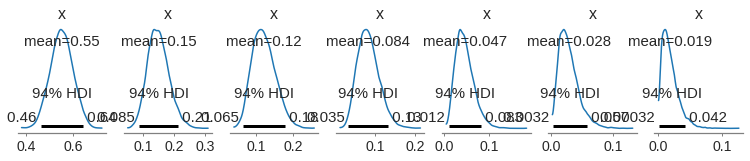

In [12]:
a = mcmc_sampling(model_catder, dict(nYlevels=nYlevels, y=Y))

plot_npdfs(a['probs'])

## 23.2 - The Case of a Single Group
Code based on https://gist.github.com/DanielWeitzenfeld/d9ac64f76281e6c1d29217af76449664

## Ordinal Probit, my own way

In [13]:
def getAmat(nYlevels):
    a = np.eye(nYlevels)
    for j in range(a.shape[0]-1):
        a[j+1,j] = -1 
    return a
# Amat = jnp.array(a)
# print(Amat)

def model_cat0(nYlevels, Amat, y=None):
    # base distribution
    loc = npr.sample('loc', dist.Normal((1+nYlevels)/2., nYlevels))
    scale = npr.sample('sigma', dist.Uniform(low=nYlevels/1000., high=nYlevels*10))
#     scale = npr.sample('sigma', dist.Exponential(1./nYlevels))
    
    with npr.plate('cut_plat', size=nYlevels-1):
        cuts = npr.sample('cuts_draw', dist.Exponential(1/2.)) # Notice: python index starts from 0, so is the outcome of Catgorical()
    cuts = jax.ops.index_update(cuts, jax.ops.index[0], 0.)  # cuts[0] = 0, cuts=[0, d1, d2, ..., d_{K-1}]
    cuts = jnp.cumsum(cuts)                                  # accumulate,  cuts=[0, d1, d1+d2, d1+d2+d2,..., \sum_k d_{k}]
    cuts = cuts * (nYlevels-2) / cuts[-1]  # cuts[5] == 5    # scale,       cuts=[0, c1, ... c_{K-2}, K-2]
    cuts = cuts + 0.5  # cuts[0] = 0.5, cuts[5] = 5.5        # shift        cuts=[.5, ..., K-2+.5]
    npr.deterministic('cuts', cuts)
    
    cdfs = jax.scipy.stats.norm.cdf(cuts, loc=loc, scale=scale)  # probit function evaluation
    cdfs = jnp.concatenate((cdfs, jnp.array([1.])))              # to convert to probs by multiply Amat
    npr.deterministic('cdfs', cdfs)
    
    probs = jnp.dot(Amat, cdfs)     # now convert to probs
    probs = jnp.maximum(0., probs)  # just to be sure, this does not happend. prob = max(0, cdf[i] - cdf[i-1]), see the matrix A
    probs = probs[:] / probs[:].sum() # just to be sure. numerical computation may produce small offset
    npr.deterministic('probs', probs)

#     probs = 
    obs = npr.sample('obs', dist.Categorical(probs=probs), obs=y)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cuts_draw[0]      2.00      1.99      1.41      0.00      4.59   8088.99      1.00
cuts_draw[1]      2.03      1.07      1.83      0.43      3.52   3306.26      1.00
cuts_draw[2]      2.07      1.11      1.85      0.47      3.71   3176.76      1.00
cuts_draw[3]      2.09      1.17      1.85      0.43      3.77   3596.73      1.00
cuts_draw[4]      1.86      1.13      1.60      0.29      3.53   3893.51      1.00
cuts_draw[5]      1.84      1.27      1.55      0.21      3.61   3656.16      1.00
         loc     -0.06      0.37     -0.04     -0.63      0.55   4613.96      1.00
       sigma      2.57      0.43      2.53      1.82      3.20   3996.75      1.00

Number of divergences: 0
CPU times: user 4.73 s, sys: 24.7 ms, total: 4.75 s
Wall time: 4.61 s


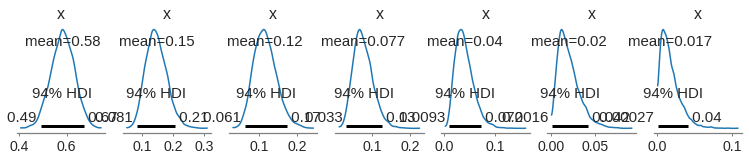

In [14]:
%%time
a = mcmc_sampling(model_cat0, dict(nYlevels=nYlevels, Amat=getAmat(nYlevels), y=Y))

plot_npdfs(a['probs'])

In [15]:
# the mean of probs is almost the same as data probabilty
_, cnts = np.unique(Y, return_counts=True)
data_prob = cnts / len(Y)
print(f'data ratio: {data_prob}')
print('posterior mean: {}'.format(a['probs'].mean(axis=0)))

data ratio: [0.58 0.15 0.12 0.08 0.04 0.02 0.01]
posterior mean: [0.5837939  0.14534815 0.11610303 0.07720126 0.03979992 0.02031543
 0.01743889]


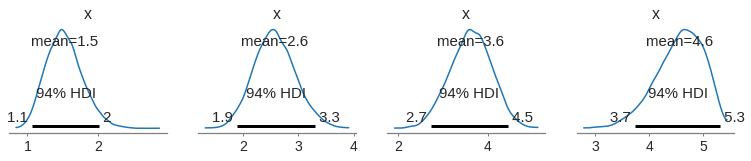

In [16]:
plot_npdfs(a['cuts'][:,1:-1])

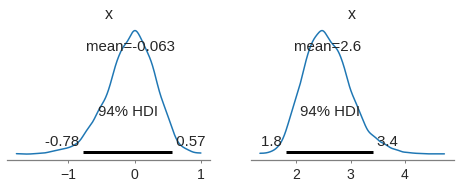

In [17]:
fig, axes = plt.subplots(1,2, figsize=(8, 2.5))
az.plot_posterior(a['loc'], ax=axes[0]);
az.plot_posterior(a['sigma'], ax=axes[1]);

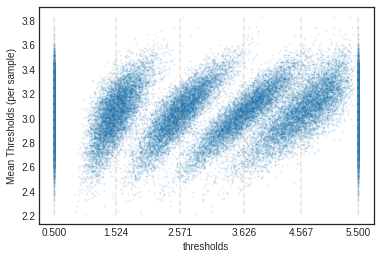

In [18]:
plot_thresholds(a['cuts'])

## Ordinal Probit, Book's way

In [19]:
def getAmat(nYlevels):
    a = np.eye(nYlevels)
    for j in range(a.shape[0]-1):
        a[j+1,j] = -1 
    return a

def model(nYlevels, Amat, y=None):
#     mu = npr.sample('mu', dist.Normal(0, 1))
#     sigma = npr.sample('sigma', dist.Uniform(low=5, high=5.2))
    mu = npr.sample('mu', dist.Normal((1. + nYlevels) / 2, nYlevels))
    sigma = npr.sample('sigma', dist.Uniform(low=nYlevels/1000, high=nYlevels*10))
#     sigma = npr.sample('sigma', dist.Exponential(1/5.))

    # cutpoints, we need K-1 thresholds
    cuts_init = jnp.array([i+.5 for i in range(nYlevels-1)])
#     print('cuts_init: ', cuts_init)
    with npr.plate('cuts_draw_plate', size=nYlevels-1):
        cuts_normal = npr.sample('cuts_normal', dist.Normal(0., 2.)) 
    cuts = cuts_init + cuts_normal
    npr.deterministic('cuts_draw', cuts)
    
    cuts = jax.ops.index_update(cuts, jax.ops.index[0], 0.5)  # cuts[0] = .5 
    cuts = jax.ops.index_update(cuts, jax.ops.index[-1], nYlevels - 1 -.5)  # cuts[-1] = 5.5
    npr.deterministic('cuts', cuts)
    
    # probit comp.
    cdfs = jax.scipy.stats.norm.cdf(cuts, loc=mu, scale=sigma)
    cdfs = jnp.concatenate((cdfs, jnp.array([1.])))
    npr.deterministic('cdf', cdfs)

    diff = jnp.dot(Amat, cdfs)
    npr.deterministic('diff', diff)
    
    max0 = jnp.maximum(0., diff)  # prob = max(0, cdf[i] - cdf[i-1]), see the matrix A
    npr.deterministic('max0', max0)
    probs = max0[:] / max0[:].sum()
    npr.deterministic('probs', probs)

    # observation
    npr.sample('obs', dist.Categorical(probs=probs), obs=y)

### Prior Predictive

In [50]:
data_prior = dict(nYlevels=nYlevels, Amat=getAmat(nYlevels))  # for Prior Predictive

s= prior_predictive(model, data_prior)

[print(k, s[k].shape) for k in s.keys()]

cdf (2021, 7)
cuts (2021, 6)
cuts_draw (2021, 6)
cuts_normal (2021, 6)
diff (2021, 7)
max0 (2021, 7)
mu (2021,)
obs (2021,)
probs (2021, 7)
sigma (2021,)


[None, None, None, None, None, None, None, None, None, None]

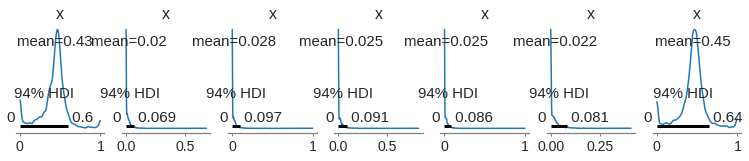

In [21]:
plot_npdfs(s['probs'])

In [22]:
1./nYlevels

0.14285714285714285

**Check**
The uniform probabilty is 1/nYlevels for each of the categories. Prior Predictive should show this number I guess.

In [23]:
s['cuts']

array([[ 0.5       ,  2.343709  ,  4.5657773 ,  7.965213  ,  3.9863625 ,
         5.5       ],
       [ 0.5       ,  2.245248  , -2.726735  ,  2.768488  ,  4.367914  ,
         5.5       ],
       [ 0.5       ,  4.749958  ,  2.3684201 ,  2.8083959 ,  4.436428  ,
         5.5       ],
       ...,
       [ 0.5       ,  1.6298653 ,  3.4521017 ,  2.5588832 ,  1.9574759 ,
         5.5       ],
       [ 0.5       ,  0.7666857 ,  2.5144172 ,  3.1733289 ,  3.205231  ,
         5.5       ],
       [ 0.5       ,  0.6929344 ,  0.10714087,  2.8980923 ,  5.683798  ,
         5.5       ]], dtype=float32)

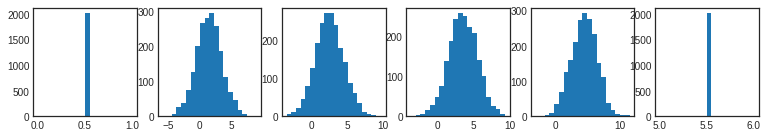

In [24]:
plot_npdfs(s['cuts'], method='hist')

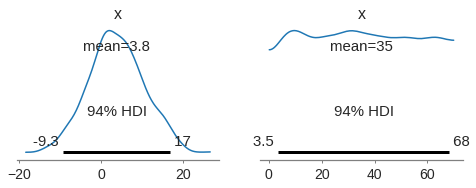

In [25]:
fig, axes = plt.subplots(1,2, figsize=(8, 2.5))
az.plot_posterior(s['mu'], ax=axes[0]);
az.plot_posterior(s['sigma'], ax=axes[1]);

### MCMC Inference

In [26]:
%%time
data = dict(nYlevels=nYlevels, Amat=getAmat(nYlevels), y=Y)   # for MCMC

ps = mcmc_sampling(model, data)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cuts_normal[0]      0.01      2.00      0.03     -3.21      3.29   6403.85      1.00
cuts_normal[1]      0.02      0.25      0.00     -0.38      0.41   3039.54      1.00
cuts_normal[2]      0.06      0.36      0.05     -0.53      0.65   2506.60      1.00
cuts_normal[3]      0.12      0.44      0.12     -0.59      0.88   2414.97      1.00
cuts_normal[4]      0.07      0.43      0.11     -0.61      0.76   2984.88      1.00
cuts_normal[5]      0.04      2.02      0.02     -3.41      3.29   4825.79      1.00
            mu     -0.06      0.36     -0.03     -0.63      0.53   4487.59      1.00
         sigma      2.56      0.42      2.53      1.89      3.25   2836.84      1.00

Number of divergences: 400
CPU times: user 4.44 s, sys: 19.8 ms, total: 4.46 s
Wall time: 4.31 s


In [27]:
ps.keys()

dict_keys(['cdf', 'cuts', 'cuts_draw', 'cuts_normal', 'diff', 'max0', 'mu', 'probs', 'sigma'])

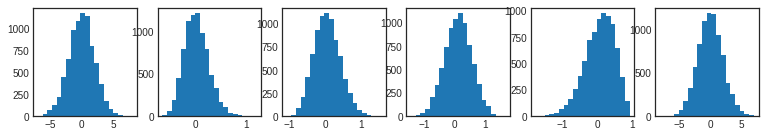

In [28]:
plot_npdfs(ps['cuts_normal'], method='hist')

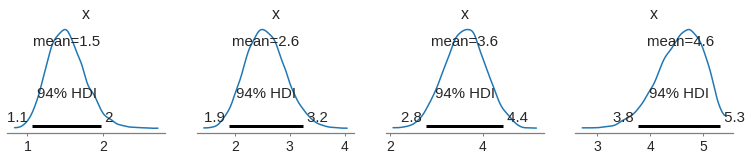

In [29]:
plot_npdfs(ps['cuts'][:,1:-1])

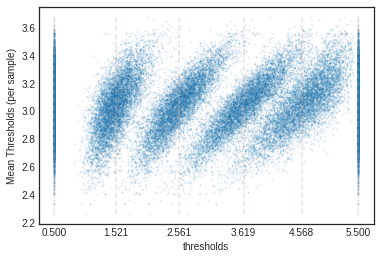

In [30]:
plot_thresholds(ps['cuts'])

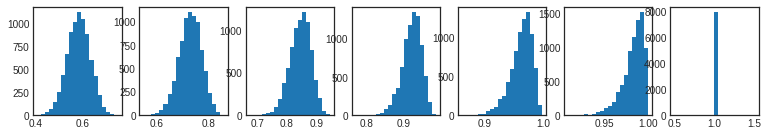

In [31]:
plot_npdfs(ps['cdf'], method='hist')

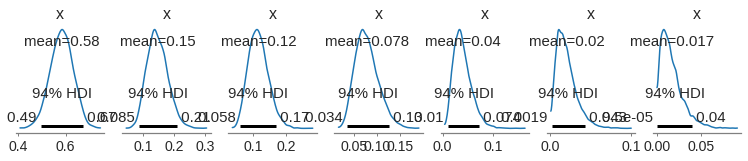

In [32]:
plot_npdfs(ps['diff'])

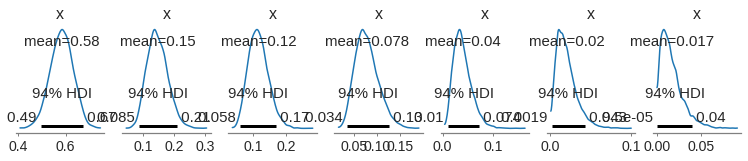

In [33]:
plot_npdfs(ps['max0'])

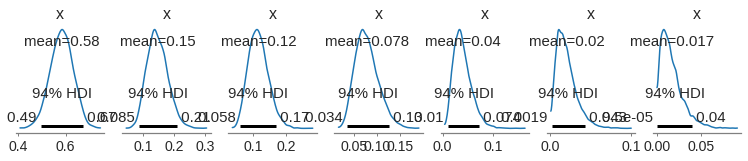

In [34]:
plot_npdfs(ps['probs'])

In [35]:
# the mean of probs is almost the same as data probabilty
_, cnts = np.unique(Y, return_counts=True)
data_prob = cnts / len(Y)
print(f'data ratio: {data_prob}')
print('posterior mean: {}'.format(ps['probs'].mean(axis=0)))

data ratio: [0.58 0.15 0.12 0.08 0.04 0.02 0.01]
posterior mean: [0.5835785  0.1456809  0.11578447 0.07768101 0.03993423 0.0202162
 0.0171253 ]


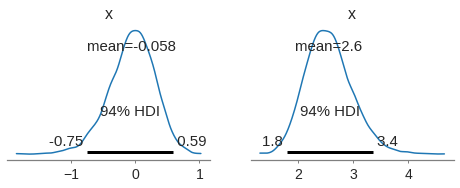

In [36]:
fig, axes = plt.subplots(1,2, figsize=(8, 2.5))
az.plot_posterior(ps['mu'], ax=axes[0]);
az.plot_posterior(ps['sigma'], ax=axes[1]);

In [37]:
x = ps['cuts'].mean(axis=0)
loc, std = ps['mu'].mean(), ps['sigma'].mean()
print(f'loc: {loc}  std: {std}')
cdfx = stats.norm(loc, std).cdf(x)
print(f'mean cut points: {x}')
print('mean cdfs: ', cdfx)
print('mean probs: ', cdfx[0],cdfx[1:]-cdfx[:-1], 1.-cdfx[-1])

loc: -0.05779753252863884  std: 2.5608603954315186
mean cut points: [0.5       1.5210322 2.5609195 3.6185756 4.567897  5.5      ]
mean cdfs:  [0.58621394 0.73122535 0.84674976 0.92444201 0.96456462 0.98500738]
mean probs:  0.5862139392705178 [0.14501141 0.11552441 0.07769225 0.04012261 0.02044276] 0.014992622607509443


**NOTE**

1. DBDA book's categorical values are 1, 2, ...., and the generating density is `Norm(1, 2.5)`
1. The computation here has categorical values 0, 1, ..., therefore the true generating density `Norm(0, 2.5)`
1. The estimated posterior densities from the two models are almost similar to the true density.
1. Likewise, the cutpoint locations have values one less than those in DBDA book.

## Another Example

In [38]:
# Using dtype 'category' for Y
df2 = pd.read_csv('data/OrdinalProbitData-1grp-2.csv', dtype={'Y':'category'})
df2.Y.value_counts().sort_index()

1     6
2    25
3     9
4     7
5     8
6    13
7     2
Name: Y, dtype: int64

In [39]:
%%time
Y2 = df2.Y.values.astype(int) - 1
data = dict(nYlevels=nYlevels, Amat=getAmat(nYlevels), y=Y2)   # for MCMC

ps = mcmc_sampling(model, data)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cuts_normal[0]      0.02      2.00      0.02     -3.08      3.42   5656.83      1.00
cuts_normal[1]      0.83      0.27      0.82      0.40      1.27   2348.24      1.00
cuts_normal[2]      0.36      0.28      0.36     -0.13      0.81   2115.76      1.00
cuts_normal[3]     -0.19      0.30     -0.19     -0.69      0.29   2123.19      1.00
cuts_normal[4]     -0.61      0.31     -0.61     -1.12     -0.09   2334.11      1.00
cuts_normal[5]      0.01      2.00     -0.03     -3.59      3.07   6288.81      1.00
            mu      2.59      0.27      2.59      2.13      3.03   2846.24      1.00
         sigma      1.61      0.19      1.60      1.31      1.90   4183.31      1.00

Number of divergences: 156
CPU times: user 4.61 s, sys: 10.3 ms, total: 4.62 s
Wall time: 4.46 s


In [40]:
ps.keys()

dict_keys(['cdf', 'cuts', 'cuts_draw', 'cuts_normal', 'diff', 'max0', 'mu', 'probs', 'sigma'])

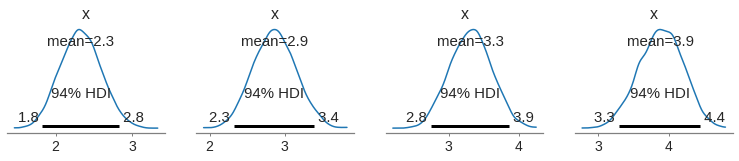

In [41]:
plot_npdfs(ps['cuts'][:,1:-1])

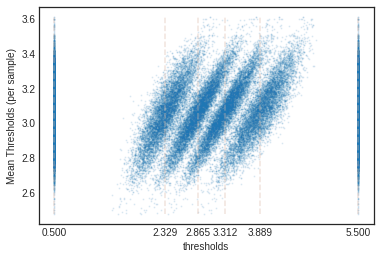

In [42]:
plot_thresholds(ps['cuts'])

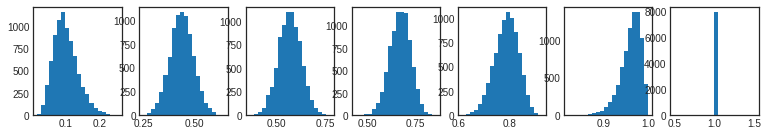

In [43]:
plot_npdfs(ps['cdf'], method='hist')

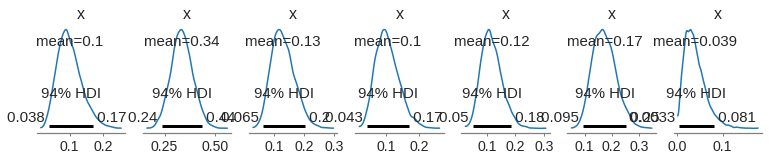

In [44]:
plot_npdfs(ps['probs'])

In [45]:
# the mean of probs is almost the same as data probabilty
_, cnts = np.unique(Y, return_counts=True)
data_prob = cnts / len(Y)
print(f'data ratio: {data_prob}')
print('posterior mean: {}'.format(ps['probs'].mean(axis=0)))

data ratio: [0.58 0.15 0.12 0.08 0.04 0.02 0.01]
posterior mean: [0.09998348 0.3360243  0.13108818 0.10464943 0.11625526 0.17290716
 0.03909084]


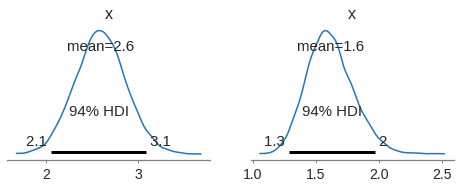

In [46]:
fig, axes = plt.subplots(1,2, figsize=(8, 2.5))
az.plot_posterior(ps['mu'], ax=axes[0]);
az.plot_posterior(ps['sigma'], ax=axes[1]);

In [47]:
x = ps['cuts'].mean(axis=0)
loc, std = ps['mu'].mean(), ps['sigma'].mean()
print(f'loc: {loc}  std: {std}')
cdfx = stats.norm(loc, std).cdf(x)
print(f'mean cut points: {x}')
print('mean cdfs: ', cdfx)
print('mean probs: ', cdfx[0],cdfx[1:]-cdfx[:-1], 1.-cdfx[-1])

loc: 2.5891101360321045  std: 1.6129088401794434
mean cut points: [0.5       2.329045  2.8645835 3.3122084 3.8893363 5.5      ]
mean cdfs:  [0.09761808 0.43595227 0.56780669 0.67303864 0.7899182  0.96444274]
mean probs:  0.097618080121534 [0.33833419 0.13185442 0.10523195 0.11687956 0.17452454] 0.03555726316513841


# Ordered Logistic in numpyro
http://num.pyro.ai/en/stable/tutorials/ordinal_regression.html

## Logistic Distribution

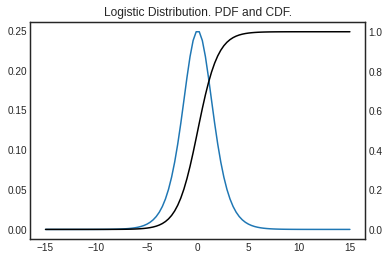

In [48]:
x = np.linspace(-15, 15, 100)
pdf = stats.logistic().pdf(x)
cdf = stats.logistic().cdf(x)
plt.plot(x, pdf, label='pdf');
plt.gca().twinx()
plt.plot(x, cdf, 'k-', label='CDF');
plt.title('Logistic Distribution. PDF and CDF.');

## Some Tests

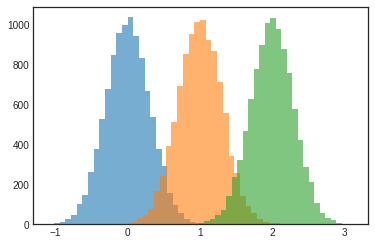

In [49]:
cuts_mu =jnp.array([0, 1., 2.])
ss = dist.Normal(cuts_mu, .3).sample(random.PRNGKey(0), (10000,))

for i in range(len(cuts_mu)):
    plt.hist(ss[:,i], lw=.1, alpha=.6, bins=30)

End.